In [1]:
#Importamos las librerías necesarias
from qiskit import QuantumCircuit, transpile
from scipy.stats import norm
from qiskit_finance.circuit.library import NormalDistribution
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import math
import numpy as np
import tensorflow as tf
from numpy import genfromtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.python.ops import math_ops
import time

In [2]:
#Parámetros de la simulación
alpha = 0.05 
num_qubits = 4
mu= 0.0
sigma = 4.16526
nivel = 1

In [32]:
#Conexión con la plataforma de IBM
tokenIBM = "8828fd4dd91a27876fb90e44c885e4efa3f7c68e1813755fe8d535d175aef929a656f9d031a897d42683f13a1b212666d5c74b663a38735a19816328b2c14809" 
service = QiskitRuntimeService(channel="ibm_quantum", token=tokenIBM)
backend = service.get_backend('ibm_kyoto')
session = Session(service=service, backend=backend)
simulator = AerSimulator()
noise_simulator = AerSimulator.from_backend(backend)

In [4]:
#Función para calcular el VaR
def CalculateVar(newCounts):
    numeros_binarios = ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
    total = 0;
    for i in range(15) :
        if (type(newCounts.get(numeros_binarios[i])) == int):
            total = total + newCounts.get(numeros_binarios[i])
        else:
            total = total
        
    j=0
    sum = 0
    while (sum/total < threshold) : 
        j = j +1
        if (type(newCounts.get(numeros_binarios[j])) == int):
            sum = sum + newCounts.get(numeros_binarios[j])
        else:
            sum = sum    
    numeros_binarios = numeros_binarios[j]
    newVar = -3*sigma + sigma*j/16
    return newVar, numeros_binarios

In [5]:
#Función para generar y ejecutar el nuevo circuito
def generateNewCircuit(circuit, new_rotations, pm, sampler, shots, executionMode):
    dag = circuit_to_dag(circuit)

    # Cambiar las rotaciones originales por la lista de nuevas rotaciones
    rotation_index = 0
    for node in dag.topological_op_nodes():
        if node.op.params:
            rotation = new_rotations[rotation_index]
            if isinstance(rotation, np.ndarray):
                rotation = rotation.tolist()
                rotation = np.array(rotation) 
                rotation = rotation[rotation_index] 
            params = [rotation]
            node.op.params = params
            rotation_index = (rotation_index + 1) % len(new_rotations)

    # Convertir el grafo aciclico directo con las nuevas rotaciones al formato de circuito
    circ = dag_to_circuit(dag)
    
    # Ejecutar y obtener resultados
    if executionMode == 1:
        result2 = simulator.run(circ, shots=shots).result()
        counts2 = result2.get_counts(circ)

    elif executionMode == 2:
        result2 = noise_simulator.run(circ, shots=shots).result()
        counts2 = result2.get_counts(circ)

    elif executionMode == 3:
        isa_circuit = pm.run(circ)
        job = sampler.run([isa_circuit], shots=shots)
        time.sleep(1)
        realJob = job.result()
        counts2 = realJob[0].data.meas.get_counts()

    else:
        raise ValueError("Invalid execution mode")
    
    
    return circ, counts2

In [6]:
''' mu = [1, 0.9]
sigma = [[1, -0.2], [-0.2, 1]]
bounds = [(0, 1), (-1, 1)]
p_x = NormalDistribution([2, 3], mu, sigma, bounds)
'''


print(norm.cdf(-3), norm.cdf(-2))
threshold = (nivel -(1-norm.cdf(-3))/(norm.cdf(-3) - norm.cdf(-2)))/100.0
print(threshold)

bounds=[-3*sigma, -2*sigma]
p_x = NormalDistribution(num_qubits, mu, sigma, bounds)
circuit = QuantumCircuit(num_qubits)
circuit.append(p_x, list(range(num_qubits)))
circuit.measure_all()
circuit.draw()

0.001349898031630093 0.0227501319481792
0.47665382530987166


┌───────┐ ░ ┌─┐         
   q_0: ┤0      ├─░─┤M├─────────
        │       │ ░ └╥┘┌─┐      
   q_1: ┤1      ├─░──╫─┤M├──────
        │  P(X) │ ░  ║ └╥┘┌─┐   
   q_2: ┤2      ├─░──╫──╫─┤M├───
        │       │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3      ├─░──╫──╫──╫─┤M├
        └───────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════╩══╩══╩══╩═
                     0  1  2  3

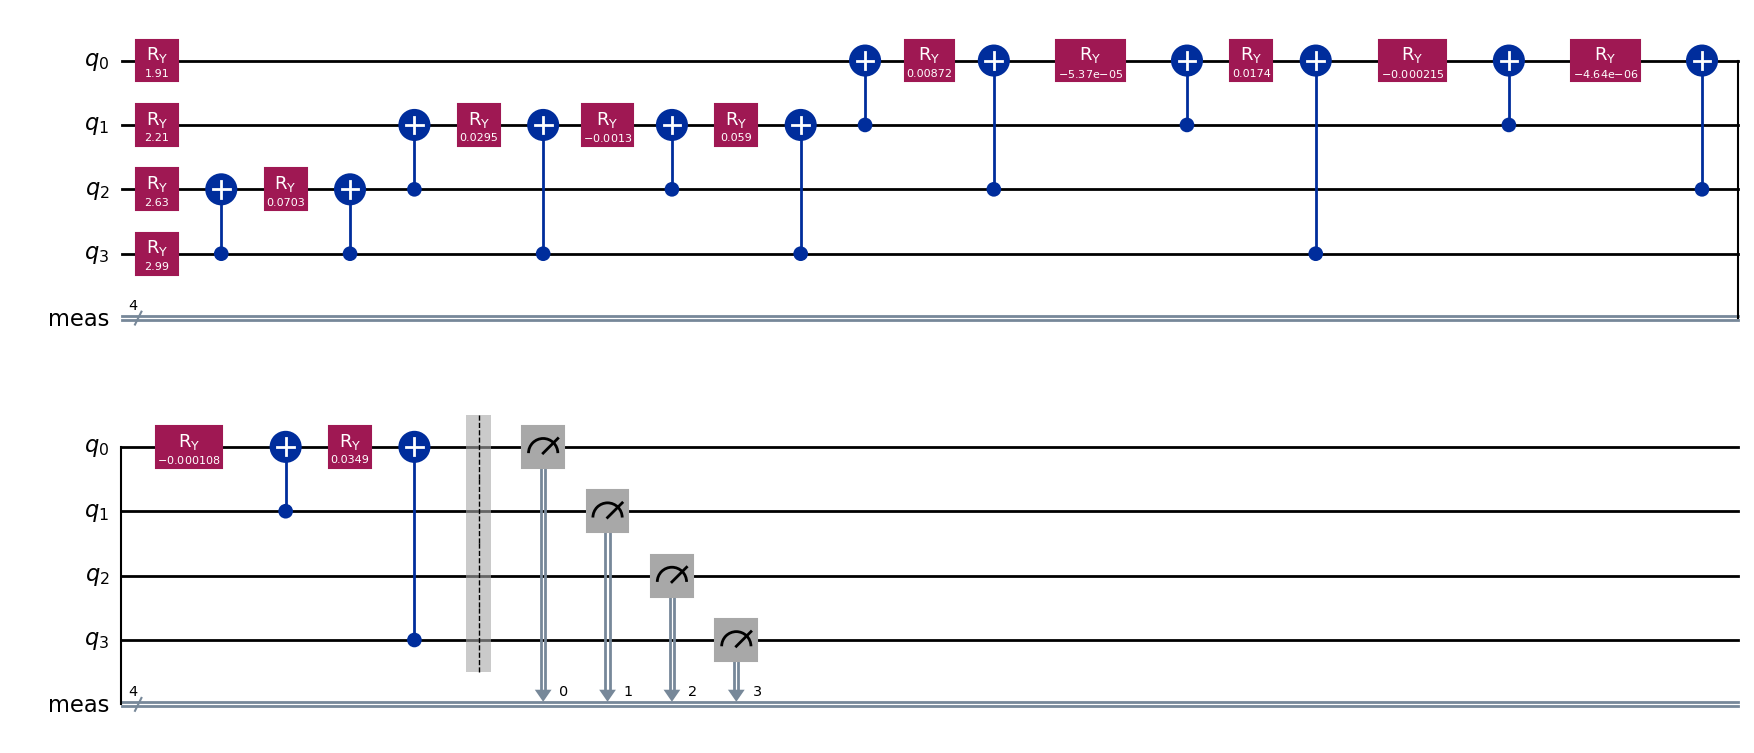

In [7]:
#Circuito original
circuit = transpile(circuit, simulator)
circuit.draw(output='mpl')

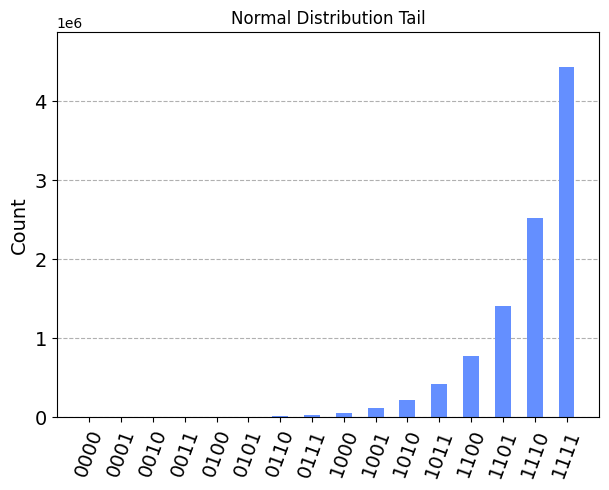

In [8]:
#Gráfica circuito original con simulador ideal
shots_sim=10e6
result_ideal = simulator.run(circuit, shots=shots_sim).result()
counts_ideal = result_ideal.get_counts(circuit)
plot_histogram(counts_ideal, title='Normal Distribution Tail', bar_labels=False)

In [9]:
#VaR circuito original con simulador ideal
var_ideal, State_ideal = CalculateVar(counts_ideal)
print ('State : ', State_ideal)
print ('VaR :', var_ideal)

State :  1101
VaR : -9.11150625


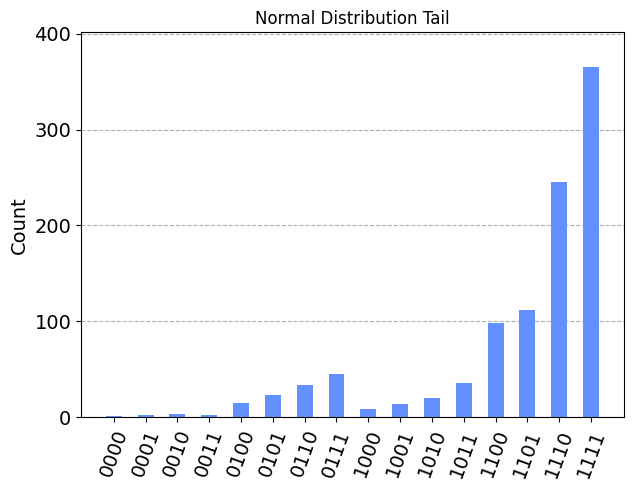

In [10]:
#Gráfica circuito original con simulador con ruido
shots_red = 1024
result_noise = noise_simulator.run(circuit, shots=shots_red).result()
counts_noise = result_noise.get_counts(circuit)
plot_histogram(counts_noise, title='Normal Distribution Tail', bar_labels=False)

In [11]:
#VaR circuito original con simulador con ruido
var_noise, State_noise = CalculateVar(counts_noise)
print ('State : ', State_noise)
print ('VaR :', var_noise)

State :  1101
VaR : -9.11150625


In [55]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
sampler = Sampler(session = session)
shots_red = 1024
isa_circuit = pm.run(circuit)

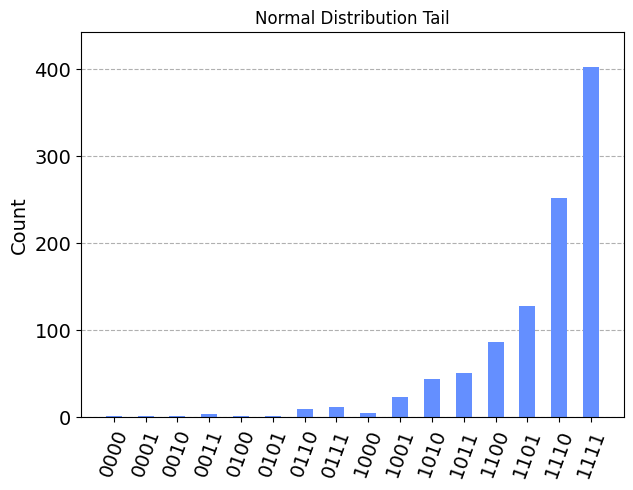

In [56]:
#Gráfica circuito original con ordenador real
job = sampler.run([isa_circuit], shots=shots_red)
result_real = job.result()
counts_real = result_real[0].data.meas.get_counts()
plot_histogram(counts_real, title='Normal Distribution Tail', bar_labels=False)

In [58]:
#VaR circuito original con ordenador real
var_real, State_real = CalculateVar(counts_real)
print ('State : ', State_real)
print ('VaR :', var_real)

State :  1101
VaR : -9.11150625


In [12]:
#Datos necesarios para el entrenamiento de la red neuornal
X_train = genfromtxt('assetData.csv', delimiter=',') #Activos financieros
Y_train = genfromtxt('varData.csv', delimiter=',') #VaR para grupos de 20 activos


assetGroup = 20 # Valor de agrupación de los datos
assetNumber = 3 # Número de columnas de activos

assetList = list()
varList = list() 

states = assetGroup * assetNumber # Input red neuronal
actions = 2**(num_qubits)-1 #Output de la red neuronal (para ordenadores reales será el número de electrones)

for ii in range(0, X_train.shape[0]-assetGroup):
    assetList.append(X_train[ii:ii+assetGroup].reshape(1,states)[0]) 


for jj in range(0, Y_train.shape[0]):
    varList.append(Y_train[jj])

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
sampler = Sampler(session = session)
shots_red = 1024

assetList = np.array(assetList)
varList = np.array(varList)

executionMode = 2 #Seleccionamos ejecución en simulador con ruido

#Función de pérdidas custom para la red neuronal
@tf.autograph.experimental.do_not_convert
def custom_loss_function(y_true, y_pred):
    y_pred_truncada = list()
    with Session(service=service, backend=backend, max_time=5000) as session :
        for ii in range(0,int(y_pred.get_shape()[0])):
            y_pred_aux = y_pred[ii] % math.pi
            newCircuit, newCounts = generateNewCircuit(circuit, y_pred_aux.numpy(), pm, sampler, shots_red, executionMode)
            varPredict, predictState = CalculateVar(newCounts)
            y_pred_truncada.append(abs(varPredict))
        y_pred_truncada = np.array(y_pred_truncada).reshape(y_pred.get_shape()[0],1) 
        y_pred_truncada_diff = abs(y_pred_truncada-y_true)
        y_pred_recortada = math_ops.abs(tf.slice(y_pred, [0, 0], [y_pred.get_shape()[0], 1]))
        y_pred_truncada_diff_sumada = y_pred_truncada_diff + y_pred_recortada
        y_pred_truncada_diff_sumada = tf.convert_to_tensor(y_pred_truncada_diff_sumada, dtype=tf.float32)

        squared_difference = tf.square(y_pred_truncada_diff_sumada - y_pred_recortada)
        return tf.reduce_mean(squared_difference, axis=-1)
    
#Función para construir el modelo de la red neuronal
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(50, input_shape=(states, ), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(actions))
    return model

#Ejecución del circuito original a través de la red neuronal utilizando un simulador con ruido
model = build_model(states, actions)
model.summary()
model.compile(optimizer='adam', loss=custom_loss_function, run_eagerly=True) 

history = model.fit(assetList, varList, epochs=20, verbose=1) 
predictedRotations_noise = model.predict(x=np.array(assetList)[60].reshape(1,states)) 
predictedRotations_noise = predictedRotations_noise[0]

print('ROTACIONES: \n', predictedRotations_noise)

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,915 (34.82 KB)

 Trainable params: 8,915 (34.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - loss: 742635.3125
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 37s/step - loss: 740119.0000
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 36s/step - loss: 740231.8750
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 77s 37s/step - loss: 727363.0000
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - loss: 751933.8750
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - loss: 753654.4375
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - loss: 749692.1875
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 78s 37s/step - loss: 745426.4375
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - loss: 778697.6875
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - loss: 736364.9375
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - loss: 735632.8125
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - loss: 752927.3750
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 80s 38s/step - loss: 737623.2500
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 79s 38s/step - loss: 734925.9375
Epoch 15/20
2/2 ━━━━━━━━━━━━━

State :  1010
VaR Predicho -9.8924925


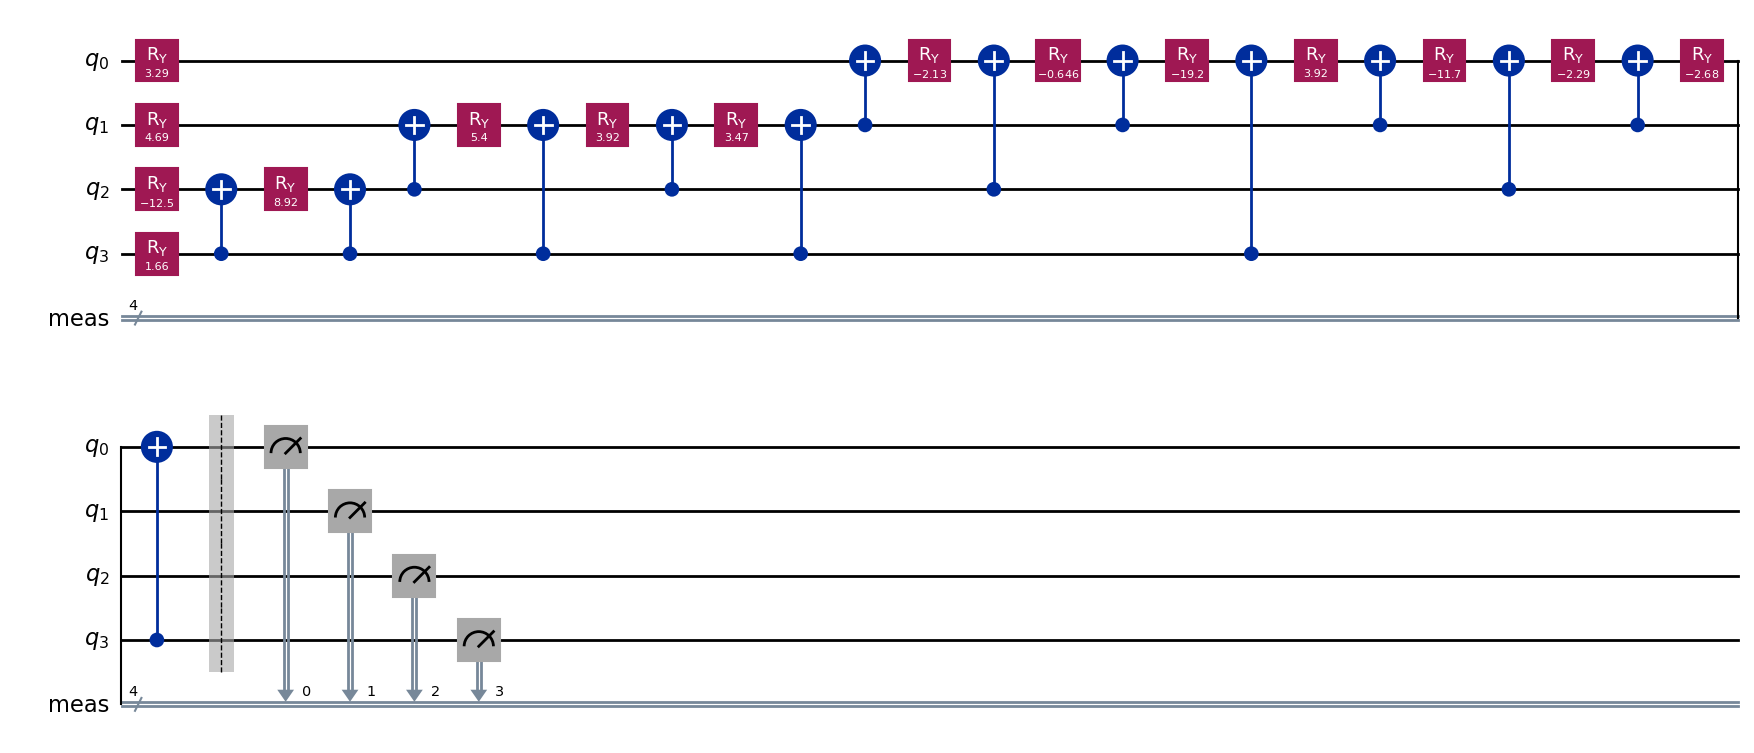

In [13]:
#Circuito en el simulador con ruido tras la predicción de la red neuronal y su respectivo valor a riesgo
newCircuit_noise, newCounts_noise = generateNewCircuit(circuit, predictedRotations_noise, pm, sampler, shots_red, executionMode)
newVar_noise, newState_noise = CalculateVar(newCounts_noise)
print ('State : ', newState_noise)
print( 'VaR Predicho', newVar_noise)

newCircuit_noise.draw(output='mpl')

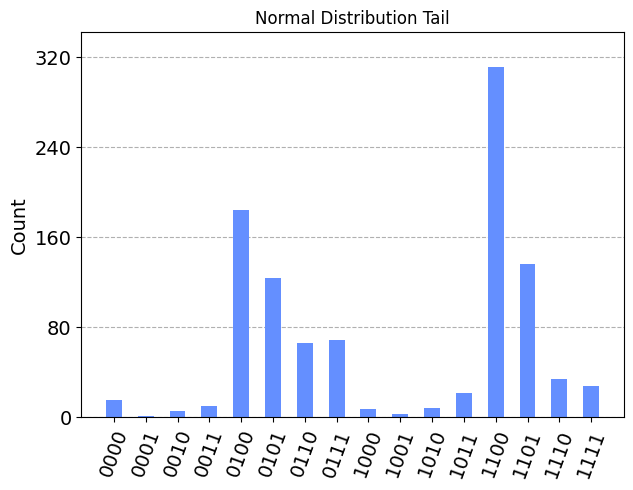

In [14]:
#Gráfica circuito en el simulador con ruido tras la predicción de la red neuronal
plot_histogram(newCounts_noise, title='Normal Distribution Tail', bar_labels=False)

In [17]:
#Datos necesarios para el entrenamiento de la red neuornal
X_train = genfromtxt('assetData.csv', delimiter=',') #Activos financieros
Y_train = genfromtxt('varData.csv', delimiter=',') #VaR para grupos de 20 activos


assetGroup = 20 # Valor de agrupación de los datos
assetNumber = 3 # Número de columnas de activos

assetList = list()
varList = list() 

states = assetGroup * assetNumber # Input red neuronal
actions = 2**(num_qubits)-1 # Output de la red neuronal (para ordenadores reales será el número de electrones)

for ii in range(0, X_train.shape[0]-assetGroup):
    assetList.append(X_train[ii:ii+assetGroup].reshape(1,states)[0]) 


for jj in range(0, Y_train.shape[0]):
    varList.append(Y_train[jj])

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
sampler = Sampler(session = session)
shots_red = 1024

assetList = np.array(assetList)
varList = np.array(varList)

executionMode = 3 #Seleccionamos el modo de ejecución para un ordenador cuántico real

#Función de pérdidas custom para la red neuronal
@tf.autograph.experimental.do_not_convert
def custom_loss_function(y_true, y_pred):
    y_pred_truncada = list()
    with Session(service=service, backend=backend, max_time=5000 ) as session :
        for ii in range(0,int(y_pred.get_shape()[0])-30):
            y_pred_aux = y_pred[ii] % math.pi
            newCircuit, newCounts = generateNewCircuit(circuit, y_pred_aux.numpy(), pm, sampler, shots_red, executionMode)
            varPredict, predictState = CalculateVar(newCounts)
            y_pred_truncada.append(abs(varPredict))
        y_pred_truncada = np.array(y_pred_truncada).reshape((y_pred.get_shape()[0]-30),1) 
        y_pred_truncada_diff = abs(y_pred_truncada-y_true)
        y_pred_recortada = math_ops.abs(tf.slice(y_pred, [0, 0], [(y_pred.get_shape()[0]-30), 1]))
        y_pred_truncada_diff_sumada = y_pred_truncada_diff + y_pred_recortada
        y_pred_truncada_diff_sumada = tf.convert_to_tensor(y_pred_truncada_diff_sumada, dtype=tf.float32)

        squared_difference = tf.square(y_pred_truncada_diff_sumada - y_pred_recortada)
        return tf.reduce_mean(squared_difference, axis=-1)
    
#Función para construir el modelo de la red neuronal
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(50, input_shape=(states, ), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(actions))
    return model



#Ejecución del circuito original a través de la red neuronal utilizando un ordenador cuántico real

model = build_model(states, actions)
model.summary()
model.compile(optimizer='adam', loss=custom_loss_function, run_eagerly=True)

history = model.fit(assetList, varList, epochs=1, verbose=1, steps_per_epoch=1) 

predictedRotations_real = model.predict(x=np.array(assetList)[60].reshape(1,states)) 
predictedRotations_real = predictedRotations_real[0]
print('ROTACIONES: \n', predictedRotations_real)

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,915 (34.82 KB)

 Trainable params: 8,915 (34.82 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 587s 587s/step - loss: 740286.1875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ROTACIONES: 
 [-5.4914231e+00 -1.9503065e+00 -5.3470140e+00 -4.0378699e+00
  7.1146381e-03 -1.7249783e+00 -5.1489396e+00 -2.3068213e+00
  4.1120486e+00 -8.7687521e+00 -6.9709885e-01  4.7234187e+00
 -2.5941200e+00  8.5683447e-01  2.6797757e+00]


State :  1011
VaR Predicho -9.63216375


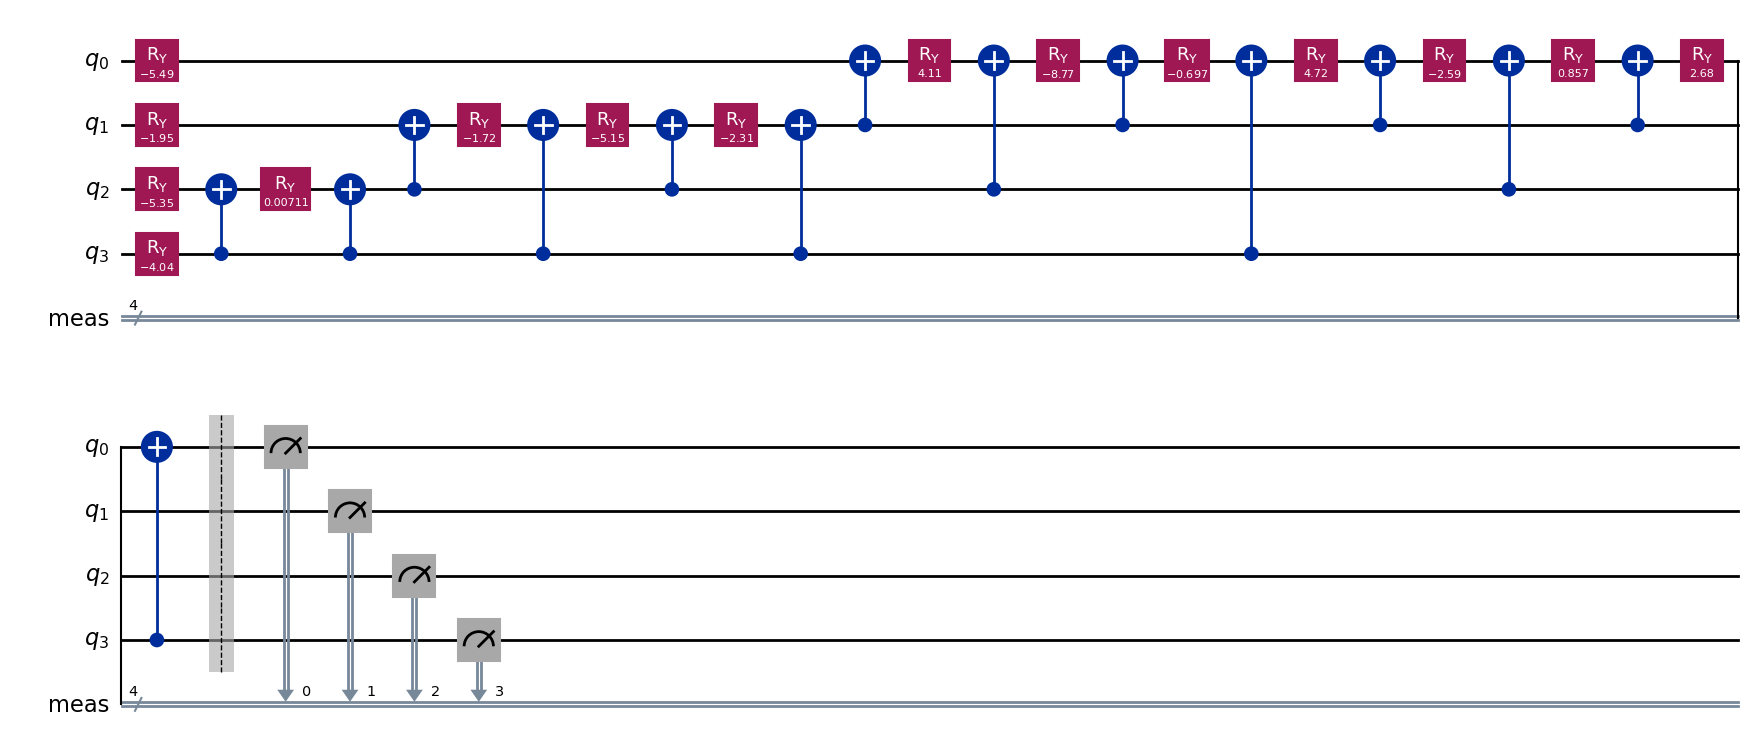

In [18]:
#Circuito en el ordenador real con ruido tras la predicción de la red neuronal y su respectivo valor a riesgo
newCircuit_real, newCounts_real = generateNewCircuit(circuit, predictedRotations_real, pm, sampler, shots_red, executionMode)
newVar_real, newState_real = CalculateVar(newCounts_real)
print ('State : ', newState_real)
print( 'VaR Predicho', newVar_real)

newCircuit_real.draw(output='mpl')

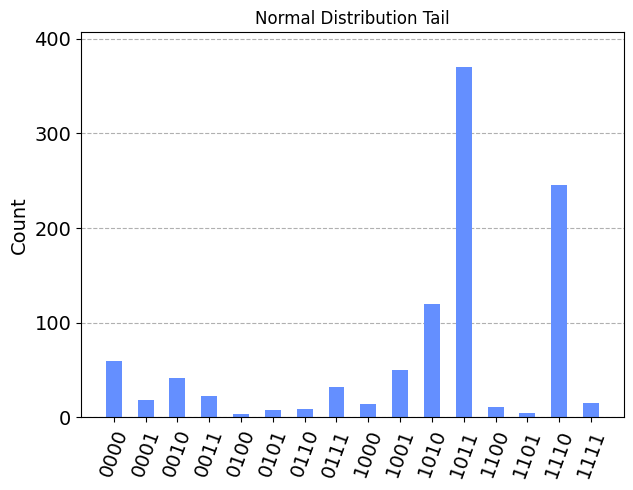

In [19]:
#Gráfica circuito en el ordenador real con ruido tras la predicción de la red neuronal
plot_histogram(newCounts_real, title='Normal Distribution Tail', bar_labels=False)

In [34]:
#Conexión con la plataforma de IBM al día siguiente
tokenIBM_nextDay = "8828fd4dd91a27876fb90e44c885e4efa3f7c68e1813755fe8d535d175aef929a656f9d031a897d42683f13a1b212666d5c74b663a38735a19816328b2c14809"
service_nextDay = QiskitRuntimeService(channel="ibm_quantum", token=tokenIBM_nextDay)
backend_nextDay = service_nextDay.get_backend('ibm_kyoto')
session_nextDay = Session(service=service_nextDay, backend=backend_nextDay)

In [35]:
pm_nextDay = generate_preset_pass_manager(backend=backend_nextDay, optimization_level=1)
sampler_nextDay = Sampler(session = session_nextDay)
shots_red_nextDay = 1024
executionMode_nextDay = 3

State :  1011
VaR Predicho -9.63216375


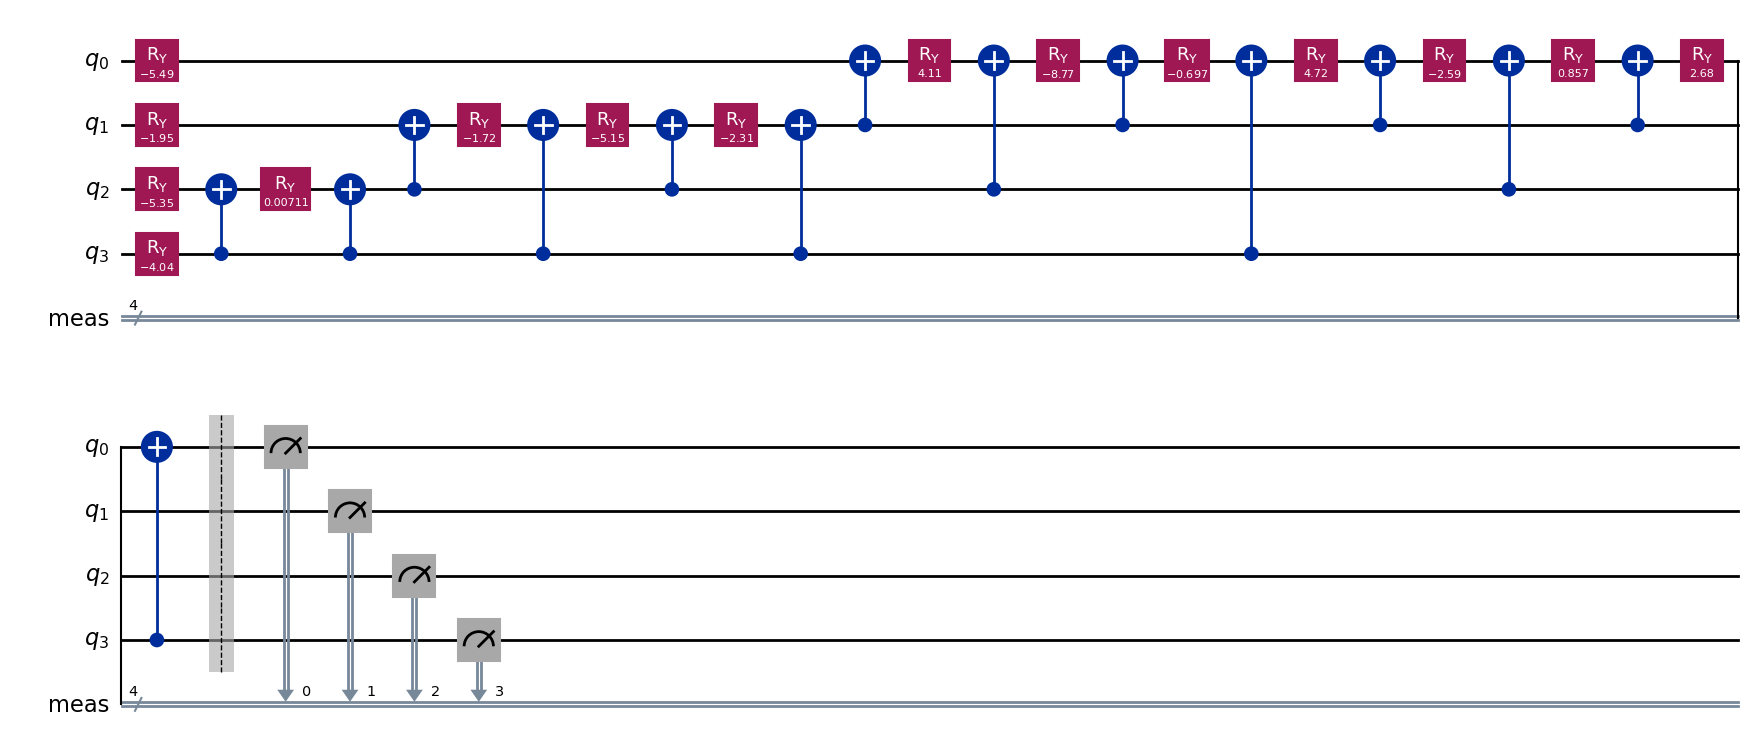

In [36]:
#Circuito en el ordenador real con ruido tras la predicción de la red neuronal al día siguiente y su respectivo valor a riesgo
nextDaynewCircuit_real, nextDaynewCounts_real = generateNewCircuit(circuit, predictedRotations_real, pm_nextDay, sampler_nextDay, shots_red_nextDay, executionMode_nextDay)
nextDaynewVar_real, nextDaynewState_real = CalculateVar(nextDaynewCounts_real)
print ('State : ', nextDaynewState_real)
print( 'VaR Predicho', nextDaynewVar_real)

nextDaynewCircuit_real.draw(output='mpl')

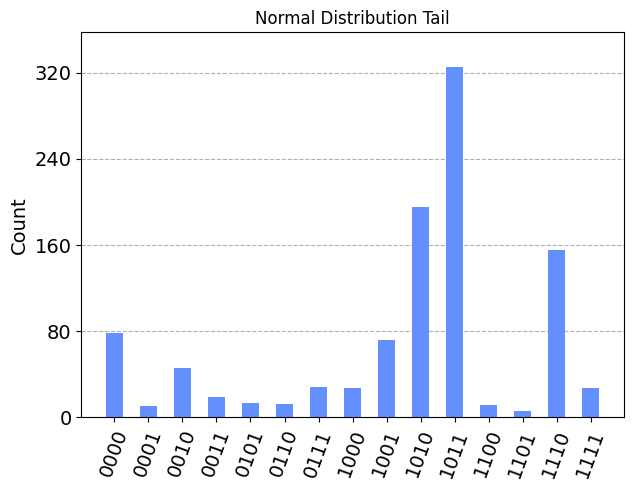

In [37]:
#Gráfica circuito en el ordenador real con ruido tras la predicción de la red neuronal al día siguiente
plot_histogram(nextDaynewCounts_real, title='Normal Distribution Tail', bar_labels=False)

In [59]:
#Conexión con la plataforma de IBM una semana después
tokenIBM_nextweek = "8828fd4dd91a27876fb90e44c885e4efa3f7c68e1813755fe8d535d175aef929a656f9d031a897d42683f13a1b212666d5c74b663a38735a19816328b2c14809"
service_nextweek = QiskitRuntimeService(channel="ibm_quantum", token=tokenIBM_nextweek)
backend_nextweek = service_nextweek.get_backend('ibm_kyoto')
session_nextweek = Session(service=service_nextweek, backend=backend_nextweek)

In [60]:
pm_nextweek = generate_preset_pass_manager(backend=backend_nextweek, optimization_level=1)
sampler_nextweek = Sampler(session = session_nextweek)
shots_red_nextweek = 1024
executionMode_nextweek = 3

State :  1011
VaR Predicho -9.63216375


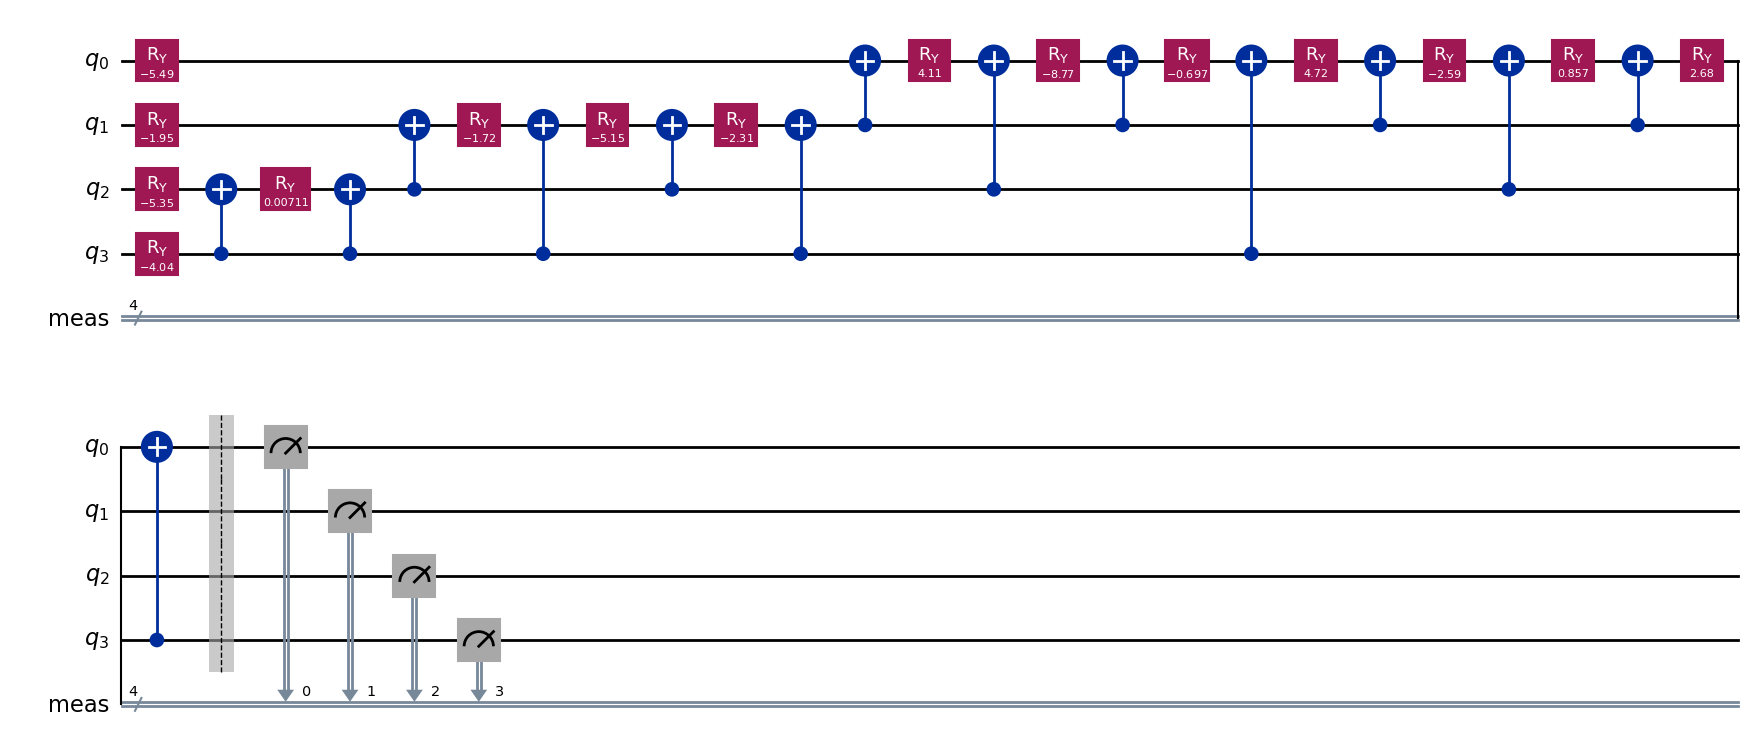

In [63]:
#Circuito en el ordenador real con ruido tras la predicción de la red neuronal una semana después y su respectivo valor a riesgo
nextweeknewCircuit_real, nextweeknewCounts_real = generateNewCircuit(circuit, predictedRotations_real, pm_nextweek, sampler_nextweek, shots_red_nextweek, executionMode_nextweek)
nextweeknewVar_real, nextweeknewState_real = CalculateVar(nextweeknewCounts_real)
print ('State : ', nextweeknewState_real)
print( 'VaR Predicho', nextweeknewVar_real)

nextweeknewCircuit_real.draw(output='mpl')

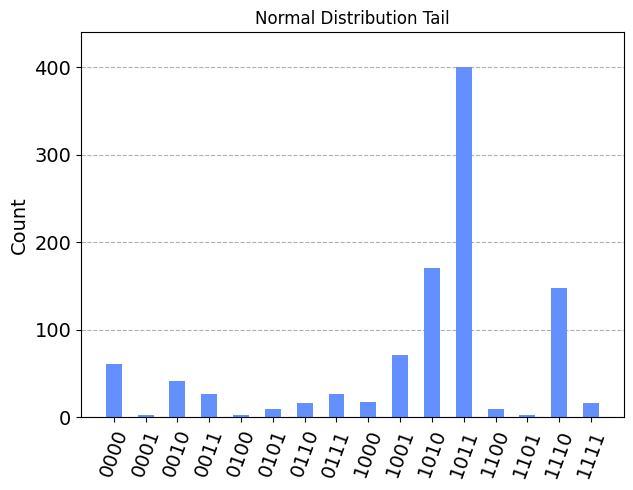

In [64]:
#Gráfica circuito en el ordenador real con ruido tras la predicción de la red neuronal una semana después
plot_histogram(nextweeknewCounts_real, title='Normal Distribution Tail', bar_labels=False)